# Import Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-git 0.11.0 requires nbdime<2.0.0,>=1.1.0, but you have nbdime 2.1.0 which is incompatible.
bokeh 2.2.3 requires tornado>=5.1, but you have tornado 5.0.2 which is incompatible.
autogluon-core 0.1.0b20210210 requires numpy==1.19, but you have numpy 1.19.5 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Preprocessing

In [2]:
IMAGE_PATH = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/'

In [3]:
n_classes = 23 

# 建立图片名列表
def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [4]:
# 划分数据集
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


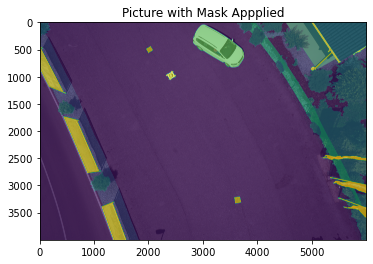

In [5]:
# 展示一张带有掩码的图像
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

# Dataset

In [6]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask) # 图像及其掩码同步进行数据增强变换
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        # 将图像转换为张量 并进行标准化
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        # 将掩码转换为长整型张量
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        # 对图像张量进行切割 创建尺寸为 512x768 的小块（图像块大小为 512x768）
        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        # 调整图像块张量的形状
        img_patches = img_patches.contiguous().view(3,-1, 512, 768)
        # 调整张量维度顺序 将图像块的维度顺序调整为 (num_tiles, channels, height, width)
        img_patches = img_patches.permute(1,0,2,3)
        
        # 对掩码张量进行类似操作
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [7]:
# 设置平均值和标准差
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# 定义训练集与验证集的图像数据增强
t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

# 建立数据集
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

# 建立数据载入器
batch_size= 3

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

# Model

In [8]:
model = smp.Unet(
    'resnet50',                 # 使用 ResNet50 编码器
    encoder_weights='imagenet',  # 依旧使用在 ImageNet 上预训练的权重
    classes=23,                  # 输出类别数仍为 23
    activation=None,             # 无激活函数，适用于交叉熵损失
    encoder_depth=5,             # 保持编码器深度为5
    decoder_channels=[256, 128, 64, 32, 16]  # 解码器的通道数
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [9]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

# Training

In [10]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1) # 通过 softmax 获取每个像素所有类别的概率分布 然后通过 argmax 沿着类别维度 (dim=1) 查找每个像素概率最大的类别 从而得到每个像素的预测类别
        correct = torch.eq(output, mask).int() # 比较预测结果和真实标签 返回一个与输入张量形状相同的布尔张量 (True/False) 表示预测值和真实标签是否一致 再转化为整数
        accuracy = float(correct.sum()) / float(correct.numel()) # 计算像素级的准确率 即正确预测的像素数与总像素数的比率 这个比率表示模型在这张图像中预测正确的像素比例

    return accuracy

In [11]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        # 对预测结果进行 softmax 然后取类别预测
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        # 将预测结果和真实标签展平为一维向量 以便后续逐像素计算交集和并集
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        # 对每个类别分别计算其 IoU
        iou_per_class = []
        for clas in range(0, n_classes): # 遍历每个类别 (从 0 到 n_classes=23 - 1)
            true_class = pred_mask == clas # 表示模型预测为当前类别的像素的 (True/False) 布尔张量
            true_label = mask == clas # 表示标签为该类别的像素的 (True/False) 布尔张量
            
            # 检查当前类别是否在像素标签中存在 如果标签中没有该类别则跳过该类别 并将 IoU 列表中当前类别位置记为缺失值
            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            # 如果标签中存在该类别 则分别计算当前类别像素的交集(大小)与并集(大小) 从而计算当前类别像素的 IoU
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [12]:
# 该函数用于获取优化器当前的学习率
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# 训练函数
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    
    # 清空 GPU 缓存 以确保在 CUDA 设备上有足够的显存进行训练
    torch.cuda.empty_cache()
    # 保存每个 epoch 的训练和验证损失
    train_losses = []
    test_losses = []
    # 保存训练和验证集的 IoU 和准确率
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    # 保存每个 epoch 的学习率
    lrs = []
    # 保存最小验证损失 用于判断模型是否有提升
    min_loss = np.inf
    # 控制模型提升情况的计数器
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    
    # 轮次循环 初始化参数
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        
        # 训练循环
        model.train() # 设置模型为训练模式
        for i, data in enumerate(tqdm(train_loader)):
            image_tiles, mask_tiles = data # 从 train_loader 中加载一个 batch 的图像和对应的分割掩码
            # 如果 patch 为 True 则将加载的图像和掩码张量的形状从五维重新调整为四维 (展平 batch_size) 以便对每个小块单独进行处理
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()
                image_tiles = image_tiles.view(-1, c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            # 将数据转移到设备
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            
            # 前向传播
            output = model(image)
            loss = criterion(output, mask)
            
            # 计算评估指标
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            
            # 反向传播
            loss.backward()
            optimizer.step() # 使用优化器更新模型的权重
            optimizer.zero_grad() # 在每次优化步骤后清空梯度以避免梯度累积
            
            # 记录学习率
            lrs.append(get_lr(optimizer))
            # 使用学习率调度器更新学习率
            scheduler.step() 
            # 将当前批次的损失添加到累积损失中
            running_loss += loss.item()
            
        else:
            # 设置模型为验证模式
            model.eval()
            
            # 初始化变量 用于跟踪验证损失 准确率和 IoU
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
    
            # 验证循环 在验证期间不需要计算梯度 其余过程与训练期间类似
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image_tiles, mask_tiles = data
                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()
                        image_tiles = image_tiles.view(-1, c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    
                    val_iou_score += mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            # 计算每个批次的平均损失 将训练和验证的平均损失添加到列表中
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            # 检查损失是否减少 如果当前验证损失小于之前的最小损失 更新 min_loss 并增加 decrease 计数器
            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                # decrease 计数器每增加 5 次便保存一次模型的状态 以便在验证损失持续改进时保存最好的模型
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-ResNet50_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            # 检查损失是否停滞 如果当前验证损失高于最小损失 增加 not_improve 计数器
            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                print(f'Loss Not Decrease for {not_improve} time')
                # 如果损失连续 7 次没有改进则提前停止训练
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            # 计算 IoU 和准确率
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            # 将每轮的训练和验证损失、IoU、准确率添加到列表中 并打印当前轮次的结果
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    # 将整个过程训练和验证的损失、IoU、准确率、学习率保存到字典中 并计算总训练时间 最后返回这个字典
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [13]:
max_lr = 1e-3 # 设置最大学习率
epoch = 15 # 设置轮次
weight_decay = 1e-4 # 设置权重衰减系数

criterion = nn.CrossEntropyLoss() # 定义损失函数为 CrossEntropyLoss (交叉熵损失)
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay) # 定义了模型的优化器为 AdamW
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader)) # 定义了学习率调度器为 OneCycleLR 这是一种动态调整学习率的策略 在训练的不同阶段有不同的学习率变化 通常从较小的学习率开始 逐渐增加到最大值 max_lr 然后再逐渐减少 这样可以加速模型训练 同时减少学习率过大带来的不稳定性


# 进行模型训练 并返回整个过程训练和验证的记录
history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.916 
Epoch:1/15.. Train Loss: 2.667.. Val Loss: 1.916.. Train mIoU:0.083.. Val mIoU: 0.130.. Train Acc:0.355.. Val Acc:0.609.. Time: 4.79m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.916 >> 1.424 
Epoch:2/15.. Train Loss: 1.778.. Val Loss: 1.424.. Train mIoU:0.140.. Val mIoU: 0.144.. Train Acc:0.606.. Val Acc:0.648.. Time: 4.58m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.424 >> 1.323 
Epoch:3/15.. Train Loss: 1.473.. Val Loss: 1.323.. Train mIoU:0.126.. Val mIoU: 0.136.. Train Acc:0.594.. Val Acc:0.634.. Time: 4.57m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.323 >> 1.306 
saving model...
Epoch:4/15.. Train Loss: 1.358.. Val Loss: 1.306.. Train mIoU:0.134.. Val mIoU: 0.134.. Train Acc:0.602.. Val Acc:0.606.. Time: 4.59m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.306 >> 1.010 
Epoch:5/15.. Train Loss: 1.280.. Val Loss: 1.010.. Train mIoU:0.152.. Val mIoU: 0.184.. Train Acc:0.621.. Val Acc:0.691.. Time: 4.55m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:6/15.. Train Loss: 1.210.. Val Loss: 1.051.. Train mIoU:0.167.. Val mIoU: 0.171.. Train Acc:0.640.. Val Acc:0.675.. Time: 4.57m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.010 >> 0.934 
Epoch:7/15.. Train Loss: 1.070.. Val Loss: 0.934.. Train mIoU:0.196.. Val mIoU: 0.194.. Train Acc:0.683.. Val Acc:0.718.. Time: 4.62m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:8/15.. Train Loss: 1.070.. Val Loss: 0.992.. Train mIoU:0.194.. Val mIoU: 0.221.. Train Acc:0.682.. Val Acc:0.713.. Time: 4.61m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.934 >> 0.819 
Epoch:9/15.. Train Loss: 0.956.. Val Loss: 0.819.. Train mIoU:0.222.. Val mIoU: 0.226.. Train Acc:0.716.. Val Acc:0.743.. Time: 4.56m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.819 >> 0.714 
Epoch:10/15.. Train Loss: 0.914.. Val Loss: 0.714.. Train mIoU:0.231.. Val mIoU: 0.262.. Train Acc:0.728.. Val Acc:0.785.. Time: 4.56m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.714 >> 0.695 
saving model...
Epoch:11/15.. Train Loss: 0.823.. Val Loss: 0.695.. Train mIoU:0.252.. Val mIoU: 0.246.. Train Acc:0.760.. Val Acc:0.788.. Time: 4.59m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.695 >> 0.646 
Epoch:12/15.. Train Loss: 0.756.. Val Loss: 0.646.. Train mIoU:0.265.. Val mIoU: 0.281.. Train Acc:0.778.. Val Acc:0.802.. Time: 4.58m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.646 >> 0.632 
Epoch:13/15.. Train Loss: 0.732.. Val Loss: 0.632.. Train mIoU:0.284.. Val mIoU: 0.291.. Train Acc:0.790.. Val Acc:0.806.. Time: 4.60m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.632 >> 0.613 
Epoch:14/15.. Train Loss: 0.685.. Val Loss: 0.613.. Train mIoU:0.289.. Val mIoU: 0.284.. Train Acc:0.801.. Val Acc:0.815.. Time: 4.61m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:15/15.. Train Loss: 0.670.. Val Loss: 0.621.. Train mIoU:0.298.. Val mIoU: 0.305.. Train Acc:0.804.. Val Acc:0.812.. Time: 4.58m
Total time: 68.95 m


In [14]:
# 将训练完成的 U-Net 模型 (主干网络为 ResNet-50) 保存到本地磁盘中的 'Unet-ResNet50.pt' 文件当中
torch.save(model, 'Unet-ResNet50.pt')

In [15]:
# 定义损失曲线绘制函数
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot(history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
# 定义 mIoU 曲线绘制函数
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

# 定义准确率曲线绘制函数
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

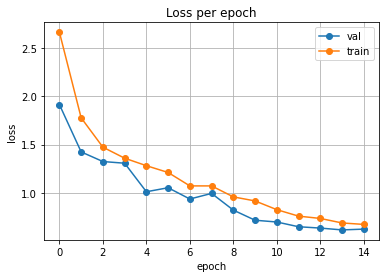

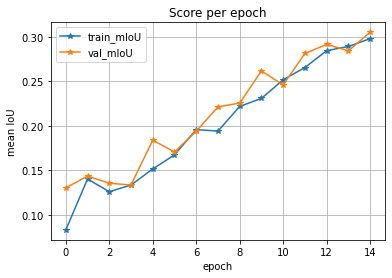

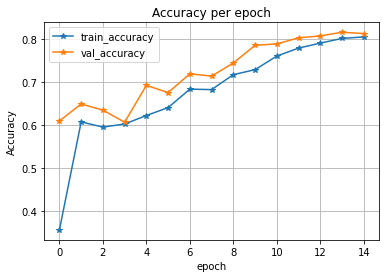

In [16]:
# 绘制三种评估曲线
plot_loss(history)
plot_score(history)
plot_acc(history)

# Evaluation

In [17]:
# 建立测试集函数 与数据集函数类似 但不需要判断是否有图像块 也不需要将图像转换为张量并进行标准化
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask

# 定义测试集的图像数据增强
t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
# 建立测试集
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

# Result

In [18]:
# 返回模型推断结果与真实掩码之间的 mIoU 以及推断掩码
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    # 将输入的原始图像通过组合变换 t 进行处理 包括转换为张量和标准化
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    # 将模型、图像和掩码移动到指定的设备
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        # 为图像和掩码增加一个批次维度 因为模型的输入通常要求有批次维度
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        # 得到模型推断结果
        output = model(image)
        # 计算模型推断结果与真实掩码之间的 mIoU
        score = mIoU(output, mask)
        # 对模型输出的每个像素 选取值最大的类别作为推断掩码
        masked = torch.argmax(output, dim=1)
        # 将推断掩码 masked 移回 CPU 并去掉之前增加的批次维度 这样得到的是二维的预测掩码 代表每个像素的分类结果
        masked = masked.cpu().squeeze(0)
    return masked, score

### 以下三个 Cells 分别可视化了测试集中的三组数据 每组数据包括原始图像、真实标签以及模型推断掩码 并显示后两者之间的 mIoU

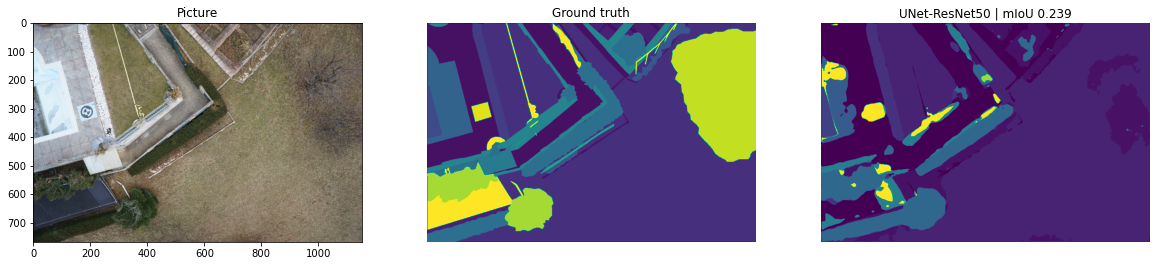

In [19]:
image1, mask1 = test_set[2]
pred_mask1, score1 = predict_image_mask_miou(model, image1, mask1)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image1)
ax1.set_title('Picture');

ax2.imshow(mask1)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask1)
ax3.set_title('UNet-ResNet50 | mIoU {:.3f}'.format(score1))
ax3.set_axis_off()

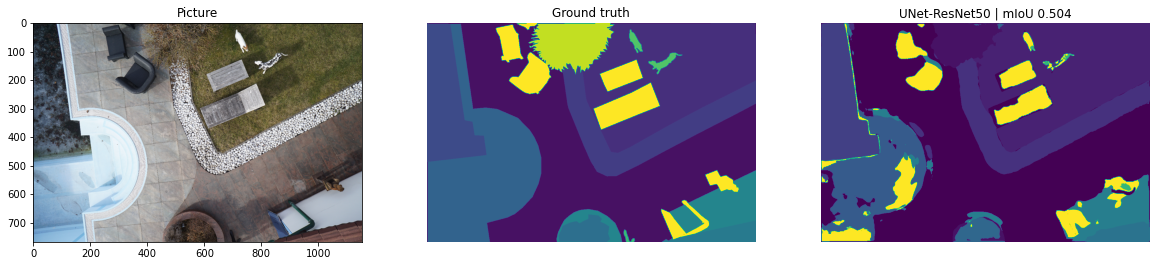

In [20]:
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-ResNet50 | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

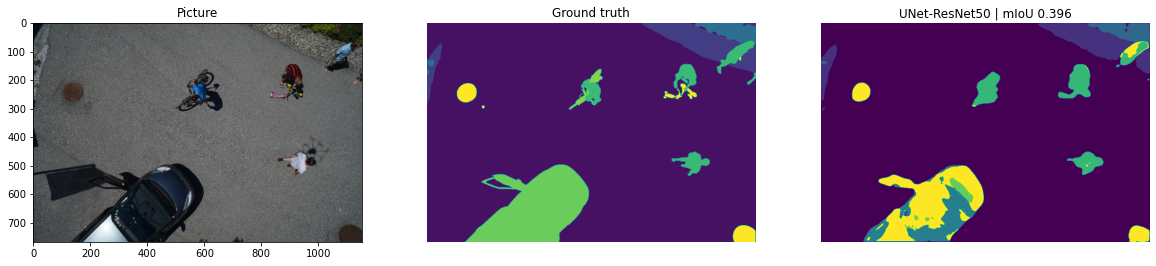

In [21]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-ResNet50 | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [22]:
# 返回保存了所有测试集样本 mIoU 的列表
def miou_list(model, test_set):
    score_miou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_miou.append(score)
    return score_miou

In [23]:
test_miou_list = miou_list(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

In [24]:
# 返回模型推断结果与真实掩码之间的像素级准确率以及推断掩码
def predict_image_mask_pixel_accuracy(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        # 计算模型推断结果与真实掩码之间的像素级准确率
        pix_acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, pix_acc

In [25]:
# 返回保存了所有测试集样本像素级准确率的列表
def pixel_accuracy_list(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel_accuracy(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [26]:
test_pixel_accuracy_list = pixel_accuracy_list(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

In [27]:
print('Test Set mIoU', np.mean(test_miou_list))

Test Set mIoU 0.325277431789347


In [28]:
print('Test Set Pixel Accuracy', np.mean(test_pixel_accuracy_list))

Test Set Pixel Accuracy 0.77830485591182
